In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
video_data = pd.read_excel('data/EEG Video Timings.xlsx')
type_col_name = list(filter(lambda s: s.startswith('Type'), video_data.columns))[0]
generalized_sz = video_data[video_data[type_col_name] == 0]
fnames = 'data/videos/' + generalized_sz['Filename']+'.mp4'

In [3]:
generalized_sz['ID'].nunique()

30

### Transform keypoints to distances and angles

#### Calculate Angles 3D

In [4]:

FRAME_WIDTH = 960
FRAME_HEIGHT = 540
def angle_between_3d(landmarks, a_img, b_img, c_img, prefix=''):
    '''Given a row of landmarks with columns x0, y0, z0 ... x32, y32, z32; and 3
    point numbers a, b, and c, this function finds the measure of angle ABC,
    with point B at the vertex. Returns angle in radians'''

    # the reference image is 1-indexed
    a = a_img - 1
    b = b_img - 1
    c = c_img - 1

    xa = landmarks[prefix+'x'+str(a)]
    ya = landmarks[prefix+'y'+str(a)]
    za = landmarks[prefix+'z'+str(a)] * FRAME_WIDTH

    xb = landmarks[prefix+'x'+str(b)]
    yb = landmarks[prefix+'y'+str(b)]
    zb = landmarks[prefix+'z'+str(b)] * FRAME_WIDTH

    xc = landmarks[prefix+'x'+str(c)]
    yc = landmarks[prefix+'y'+str(c)]
    zc = landmarks[prefix+'z'+str(c)] * FRAME_WIDTH

    side_a = np.sqrt(np.power(xb - xc, 2) + np.power(yb - yc, 2) + np.power(zb - zc, 2))
    side_b = np.sqrt(np.power(xa - xc, 2) + np.power(ya - yc, 2) + np.power(za - zc, 2))
    side_c = np.sqrt(np.power(xb - xa, 2) + np.power(yb - ya, 2) + np.power(zb - za, 2))

    numer = np.power(side_a, 2) + np.power(side_c, 2) - np.power(side_b, 2)
    denom = 2 * side_a * side_c
    try:
        return np.arccos(numer/denom)
        # return np.abs(np.arctan((yc - yb) / (xc - xb)) - np.arctan((ya - yb) / (xa - xb)))
    except ZeroDivisionError:
        return np.nan


def distance_between_3d(landmarks, a_img, b_img, prefix=''):
    a = a_img - 1
    b = b_img - 1

    xa = landmarks[prefix+'x'+str(a)]
    ya = landmarks[prefix+'y'+str(a)]
    za = landmarks[prefix+'z'+str(a)] * FRAME_WIDTH

    xb = landmarks[prefix+'x'+str(b)]
    yb = landmarks[prefix+'y'+str(b)]
    zb = landmarks[prefix+'z'+str(b)] * FRAME_WIDTH

    return np.sqrt((xa - xb) **2 + (ya - yb) **2 + (za - zb) ** 2)

#### Calculate Angles 2D

In [5]:
import numpy as np
def angle_between(landmarks, a_img, b_img, c_img, prefix=''):
    '''Given a row of landmarks with columns x0, y0, z0 ... x32, y32, z32; and 3
    point numbers a, b, and c, this function finds the measure of angle ABC,
    with point B at the vertex. Returns angle in radians'''

    # the reference image is 1-indexed
    a = a_img - 1
    b = b_img - 1
    c = c_img - 1

    xa = landmarks[prefix+'x'+str(a)]
    ya = landmarks[prefix+'y'+str(a)]
    # za = landmarks[prefix+'z'+str(a)] * FRAME_WIDTH

    xb = landmarks[prefix+'x'+str(b)]
    yb = landmarks[prefix+'y'+str(b)]
    # zb = landmarks[prefix+'z'+str(b)] * FRAME_WIDTH

    xc = landmarks[prefix+'x'+str(c)]
    yc = landmarks[prefix+'y'+str(c)]
    # zc = landmarks[prefix+'z'+str(c)] * FRAME_WIDTH

    side_a = np.sqrt(np.power(xb - xc, 2) + np.power(yb - yc, 2))
    side_b = np.sqrt(np.power(xa - xc, 2) + np.power(ya - yc, 2))
    side_c = np.sqrt(np.power(xb - xa, 2) + np.power(yb - ya, 2))

    numer = np.power(side_a, 2) + np.power(side_c, 2) - np.power(side_b, 2)
    denom = 2 * side_a * side_c
    try:
        return np.arccos(numer/denom)
        # return np.abs(np.arctan((yc - yb) / (xc - xb)) - np.arctan((ya - yb) / (xa - xb)))
    except ZeroDivisionError:
        return np.nan


def distance_between(landmarks, a_img, b_img, prefix=''):
    a = a_img - 1
    b = b_img - 1

    xa = landmarks[prefix+'x'+str(a)]
    ya = landmarks[prefix+'y'+str(a)]
    # za = landmarks[prefix+'z'+str(a)] * FRAME_WIDTH

    xb = landmarks[prefix+'x'+str(b)]
    yb = landmarks[prefix+'y'+str(b)]
    # zb = landmarks[prefix+'z'+str(b)] * FRAME_WIDTH

    return np.sqrt((xa - xb) **2 + (ya - yb) **2)

In [6]:
angles = ['R_axilla', 'L_axilla', 'R_elbow', 'L_elbow', 'R_ulnar_wrist', 
          'L_ulnar_wrist', 'R_thumb', 'L_thumb', 'R_hip', 'L_hip', 'R_knee',
          'L_knee', 'R_neck', 'L_neck', 'R_arm', 'L_arm', 'R_forearm',
          'L_forearm', 'R_thigh', 'L_thigh', 'R_leg', 'L_leg', 
          
          'R_mouth_angle',
          'Upper_mouth_0', 'Upper_mouth_1', 
          'Upper_mouth_2', 'Upper_mouth_3', 'Upper_mouth_4', 
          'L_mouth_angle', 
          'Lower_mouth_0', 'Lower_mouth_1', 
          'Lower_mouth_2', 'Lower_mouth_3', 'Lower_mouth_4',
          
          'R_lateral_canthus', 
          'R_medial_canthus',
          'L_lateral_canthus', 
          'L_medial_canthus',

          'R_eye_height',
          'L_eye_height',
          'Mouth_height',

          # *['v'+str(i) for i in range(33)]
          ]
# add column labels for confidences at the end
conf_labels = ['conf'+str(i) for i in range(133)]
for col in conf_labels:
    angles.append(col)

def all_the_angles(df) -> pd.DataFrame:
    '''
    Given a df of pose landmarks, returns an array of important angles to
    remove location-dependency of data

    see MediaPipe docs for the pose mapping: 
    https://google.github.io/mediapipe/solutions/pose.html'''

    column_data = [
        ### POSE
        angle_between_3d(df, 9, 7, 13), # R axilla
        angle_between_3d(df, 8, 6, 12), # L axilla
        angle_between_3d(df, 7, 9, 11), # R elbow
        angle_between_3d(df, 6, 8, 10), # L elbow
        angle_between(df, 9, 11, 130), # R ulnar wrist
        angle_between(df, 8, 10, 109), # L ulnar wrist
        angle_between(df, 9, 11, 118), # R thumb
        angle_between(df, 8, 10, 97), # L thumb
        angle_between_3d(df, 7, 13, 15), # R hip
        angle_between_3d(df, 6, 12, 14), # L hip
        angle_between_3d(df, 13, 15, 17), # R knee
        angle_between_3d(df, 12, 14, 16), # L knee
        angle_between_3d(df, 1, 5, 7),   # R "neck"
        angle_between_3d(df, 1, 4, 6),   # L "neck"

        distance_between_3d(df, 7, 9),  # R arm
        distance_between_3d(df, 6, 8),  # L arm
        distance_between_3d(df, 9, 11),  # R forearm
        distance_between_3d(df, 8, 10),  # L forearm
        distance_between_3d(df, 13, 15),  # R thigh
        distance_between_3d(df, 12, 14),  # L thigh
        distance_between_3d(df, 15, 17),  # R leg
        distance_between_3d(df, 14, 16),  # L leg
        ### FACE
        angle_between(df, 83, 72, 73), # R mouth angle
        angle_between(df, 72, 73, 74),
        angle_between(df, 73, 74, 75),
        angle_between(df, 74, 75, 76),
        angle_between(df, 75, 76, 77),
        angle_between(df, 76, 77, 78),
        angle_between(df, 77, 78, 79), # L mouth angle
        angle_between(df, 78, 79, 80),
        angle_between(df, 79, 80, 81),
        angle_between(df, 80, 81, 82),
        angle_between(df, 81, 82, 83),
        angle_between(df, 82, 83, 72),

        ### EYES
        angle_between(df, 65, 60, 61),  # R lateral canthus
        angle_between(df, 62, 63, 64),  # R medial canthus
        angle_between(df, 70, 69, 68),  # L lateral canthus
        angle_between(df, 67, 66, 71),  # L medial canthus

        distance_between(df, 62, 64), # R eye height
        distance_between(df, 67, 71), # L eye height
        distance_between(df, 86, 90), # mouth height
    ]
    confs = df[conf_labels]
    column_data = np.append(np.array(column_data).transpose(), confs, axis=1) 

    new_df = pd.DataFrame(data=column_data)
    new_df.columns = angles
    return new_df

def compute_angles(df: pd.DataFrame):
    df_angles = all_the_angles(df)
    df_angles['class'] = df['class']
    if 'pt_id' in df.columns:
        df_angles['pt_id'] = df['pt_id']
    if 'vid_id' in df.columns:
        df_angles['vid_id'] = df['vid_id']
    # SKLearn's HistGradientBoostingClassifier cna handle NA values,
    # so I'd like to see how that works
    #return df_angles.drop('vid_id', axis=1)
    #return df_angles.groupby(df_angles['vid_id']).fillna(method='ffill')
    return df_angles.groupby(df_angles['vid_id']).ffill()

#### Relational Features

In [7]:
import numpy as np
from scipy.signal import correlation_lags, correlate
import pandas as pd

def compute_relational_features(df_angles: pd.DataFrame) -> pd.DataFrame:
    """
    Compute relational features between joints using adaptive window sizes.
    Args:
        df_angles: DataFrame with angle measurements
    Returns:
        DataFrame with computed relational features
    """
    print("Starting relational features calculation...")
    all_results = {}
    
    # Define window sizes for different joint pairs (in frames)
    WINDOW_SIZES = {
        # Slower, larger movements
        'hip_knee': 90,     # 3 seconds for full leg movement cycles
        'hip_thigh': 90,
        'knee_leg': 90,
        
        # Medium speed movements
        'shoulder_elbow': 60,  # 2 seconds for arm movements
        'elbow_wrist': 60,
        'neck_shoulder': 60,
        
        # Quick movements
        'eye': 30,          # 1 second for rapid facial movements
        'mouth': 30,
        'wrist_hand': 30,
        
        # Default for undefined pairs
        'default': 60
    }
    
    # Define joint pairs with their corresponding window size keys
    joint_configs = {
        # Slower movement pairs
        ('R_hip', 'R_knee'): 'hip_knee',
        ('L_hip', 'L_knee'): 'hip_knee',
        ('R_hip', 'R_thigh'): 'hip_thigh',
        ('L_hip', 'L_thigh'): 'hip_thigh',
        ('R_knee', 'R_leg'): 'knee_leg',
        ('L_knee', 'L_leg'): 'knee_leg',
        
        # Medium speed pairs
        ('R_axilla', 'R_elbow'): 'shoulder_elbow',
        ('L_axilla', 'L_elbow'): 'shoulder_elbow',
        ('R_elbow', 'R_ulnar_wrist'): 'elbow_wrist',
        ('L_elbow', 'L_ulnar_wrist'): 'elbow_wrist',
        ('R_neck', 'R_axilla'): 'neck_shoulder',
        ('L_neck', 'L_axilla'): 'neck_shoulder',
        
        # Quick movement pairs
        ('R_eye_height', 'L_eye_height'): 'eye',
        ('R_lateral_canthus', 'L_lateral_canthus'): 'eye',
        ('R_medial_canthus', 'L_medial_canthus'): 'eye',
        ('R_mouth_angle', 'L_mouth_angle'): 'mouth',
        ('R_ulnar_wrist', 'R_thumb'): 'wrist_hand',
        ('L_ulnar_wrist', 'L_thumb'): 'wrist_hand'
    }
    
    # Process each video separately
    for vid in df_angles['vid_id'].unique():
        vid_mask = df_angles['vid_id'] == vid
        print(f"Processing video: {vid}")
        
        vid_data = df_angles[vid_mask]
        n_frames = len(vid_data)
        
        # Process each joint pair
        for (joint1, joint2), movement_type in joint_configs.items():
            window_size = WINDOW_SIZES.get(movement_type, WINDOW_SIZES['default'])
            
            # Skip if either column is missing
            if joint1 not in vid_data.columns or joint2 not in vid_data.columns:
                continue
                
            # 1. Compute correlation with appropriate window size
            corr_vals = np.zeros(n_frames)
            for i in range(window_size, n_frames):
                win1 = vid_data[joint1].iloc[i-window_size:i].values
                win2 = vid_data[joint2].iloc[i-window_size:i].values
                
                if np.std(win1) > 1e-6 and np.std(win2) > 1e-6:
                    corr_vals[i] = np.corrcoef(win1, win2)[0,1]
            
            feature_name = f'corr_{movement_type}_{joint1}_{joint2}'
            all_results[feature_name] = np.zeros(len(df_angles))
            all_results[feature_name][vid_data.index] = corr_vals
            
            # 2. For symmetric pairs, compute additional features
            if joint1[:2] in ['R_', 'L_'] and joint2[:2] in ['R_', 'L_']:
                # Compute symmetry ratio
                ratio = vid_data[joint1] / (vid_data[joint2] + np.finfo(float).eps)
                ratio_name = f'sym_ratio_{movement_type}_{joint1[2:]}_{joint2[2:]}'
                all_results[ratio_name] = np.zeros(len(df_angles))
                all_results[ratio_name][vid_data.index] = ratio
                
                # Compute moving average of absolute difference
                diff = np.abs(vid_data[joint1] - vid_data[joint2])
                diff_vals = np.zeros(n_frames)
                for i in range(window_size, n_frames):
                    diff_vals[i] = np.mean(diff.iloc[i-window_size:i])
                
                diff_name = f'sym_diff_{movement_type}_{joint1[2:]}_{joint2[2:]}'
                all_results[diff_name] = np.zeros(len(df_angles))
                all_results[diff_name][vid_data.index] = diff_vals
    
    print("Relational features calculation complete.")
    return pd.DataFrame(all_results, index=df_angles.index)

#### FFT

In [8]:
import numpy as np
from scipy.fft import fft
import pandas as pd

def compute_fft_features(df_angles: pd.DataFrame, window_size: int = 90, n_freqs: int = 5) -> pd.DataFrame:
    """
    Compute FFT features for angle columns using rolling windows with improved performance.
    """
    print("Starting FFT calculations...")
    
    # Get only angle columns by filtering out known non-angle columns
    #non_angle_cols = ['class', 'pt_id', 'vid_id'] + [f'conf{i}' for i in range(133)]
    non_angle_cols = ['class', 'pt_id', 'vid_id'] + [f'conf{i}' for i in range(133)] + ['xmin', 'ymin', 'xmax', 'ymax']
    angle_cols = [col for col in df_angles.columns if col not in non_angle_cols]
    
    # Dictionary to store all results
    all_results = {}
    
    # Process each video separately
    for vid in df_angles['vid_id'].unique():
        vid_mask = df_angles['vid_id'] == vid
        print(f"Processing FFT for video: {vid}")
        
        # Process each angle column
        for angle_col in angle_cols:
            # Get the angle data for this video
            angle_data = df_angles.loc[vid_mask, angle_col].values
            
            # Initialize array for FFT results
            fft_results = np.zeros((len(angle_data), n_freqs))
            
            # Compute FFT for each window
            for i in range(len(angle_data)):
                if i < window_size:
                    # For initial windows, use available data
                    window = angle_data[:i+1]
                    # Pad with zeros to match window_size
                    padded_window = np.pad(window, (0, window_size - len(window)), 'constant')
                else:
                    # For full windows
                    window = angle_data[i-window_size+1:i+1]
                    padded_window = window  # No padding needed
                
                if len(padded_window) > 0:
                    fft_result = fft(padded_window)
                    fft_results[i, :] = np.abs(fft_result[:n_freqs])
            
            # Store results for each frequency
            for freq in range(n_freqs):
                col_name = f'fft_{angle_col}_{freq}'
                if col_name not in all_results:
                    all_results[col_name] = np.zeros(len(df_angles))
                all_results[col_name][df_angles[df_angles['vid_id'] == vid].index] = fft_results[:, freq]
    
    print("FFT calculations complete. Creating DataFrame...")
    # Create DataFrame all at once
    fft_features = pd.DataFrame(all_results, index=df_angles.index)
    
    return fft_features.fillna(0)

#### Pause Metrics

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def compute_pause_metrics(df_angles: pd.DataFrame, window_size: int = 30, 
                        velocity_threshold: float = 0.01) -> pd.DataFrame:
    """
    Compute pause metrics for each joint angle.
    Captures periods of minimal movement that could indicate seizure-related freezing.
    
    Args:
        df_angles: DataFrame with angle measurements
        window_size: Window size in frames (default 1 second at 30fps)
        velocity_threshold: Threshold below which movement is considered paused
    """
    print("Computing pause metrics...")
    all_results = {}
    
    # Filter out non-angle columns
    #non_angle_cols = ['class', 'pt_id', 'vid_id'] + [f'conf{i}' for i in range(133)]
    non_angle_cols = ['class', 'pt_id', 'vid_id'] + [f'conf{i}' for i in range(133)] + ['xmin', 'ymin', 'xmax', 'ymax']
    angle_cols = [col for col in df_angles.columns if col not in non_angle_cols]
    
    for vid in df_angles['vid_id'].unique():
        vid_mask = df_angles['vid_id'] == vid
        vid_data = df_angles[vid_mask]
        
        for col in angle_cols:
            # Compute velocity
            velocity = np.abs(np.diff(vid_data[col], prepend=vid_data[col].iloc[0]))
            
            # Identify pauses (where velocity is below threshold)
            pauses = velocity < velocity_threshold
            
            # Compute pause features in rolling windows
            pause_ratio = np.zeros(len(vid_data))
            pause_duration = np.zeros(len(vid_data))
            
            for i in range(window_size, len(vid_data)):
                window = pauses[i-window_size:i]
                pause_ratio[i] = np.mean(window)
                
                # Find longest continuous pause in window
                pause_runs = np.diff(np.where(np.concatenate(([window[0]], 
                                                            window[:-1] != window[1:], 
                                                            [True])))[0])
                pause_duration[i] = np.max(pause_runs * window[0]) if any(pause_runs) else 0
            
            # Store results
            all_results[f'pause_ratio_{col}'] = np.zeros(len(df_angles))
            all_results[f'pause_ratio_{col}'][vid_data.index] = pause_ratio
            
            all_results[f'pause_duration_{col}'] = np.zeros(len(df_angles))
            all_results[f'pause_duration_{col}'][vid_data.index] = pause_duration
    
    return pd.DataFrame(all_results, index=df_angles.index)

#### Angular Displacement

In [10]:
def compute_angular_displacement(df_angles: pd.DataFrame, window_size: int = 30) -> pd.DataFrame:
    """
    Optimized computation of angular displacement features (HOAD2D).
    
    Args:
        df_angles: DataFrame with angle measurements
        window_size: Window size in frames (default 1 second at 30fps)
    """
    print("Computing angular displacement features...")
    
    # Pre-filter columns
    #non_angle_cols = ['class', 'pt_id', 'vid_id'] + [f'conf{i}' for i in range(133)]
    non_angle_cols = ['class', 'pt_id', 'vid_id'] + [f'conf{i}' for i in range(133)] + ['xmin', 'ymin', 'xmax', 'ymax']
    angle_cols = [col for col in df_angles.columns if col not in non_angle_cols]
    
    # Initialize results dictionary
    results_dict = {}
    
    # Process each video
    for vid in df_angles['vid_id'].unique():
        print(f"Processing video: {vid}")
        vid_mask = df_angles['vid_id'] == vid
        vid_data = df_angles.loc[vid_mask, angle_cols].values  # Convert to numpy for speed
        
        n_frames = len(vid_data)
        n_angles = len(angle_cols)
        
        # Pre-allocate arrays for results
        total_displacement = np.zeros((n_frames, n_angles))
        mean_displacement = np.zeros((n_frames, n_angles))
        std_displacement = np.zeros((n_frames, n_angles))
        
        # Compute absolute differences for all angles at once
        abs_diffs = np.abs(np.diff(vid_data, axis=0))
        
        # Use cumsum for efficient rolling window
        cumsum = np.cumsum(abs_diffs, axis=0)
        
        # Compute rolling sum of displacement
        for i in range(window_size, n_frames):
            if i >= window_size:
                start_idx = i - window_size
                window_diffs = abs_diffs[start_idx:i]
                
                total_displacement[i] = np.sum(window_diffs, axis=0)
                mean_displacement[i] = np.mean(window_diffs, axis=0)
                std_displacement[i] = np.std(window_diffs, axis=0)
        
        # Store results
        for j, col in enumerate(angle_cols):
            results_dict[f'angdisp_{col}_total'] = np.zeros(len(df_angles))
            results_dict[f'angdisp_{col}_total'][vid_mask] = total_displacement[:, j]
            
            results_dict[f'angdisp_{col}_mean'] = np.zeros(len(df_angles))
            results_dict[f'angdisp_{col}_mean'][vid_mask] = mean_displacement[:, j]
            
            results_dict[f'angdisp_{col}_std'] = np.zeros(len(df_angles))
            results_dict[f'angdisp_{col}_std'][vid_mask] = std_displacement[:, j]
    
    return pd.DataFrame(results_dict, index=df_angles.index)

#### Angle Histogram

In [11]:
import numpy as np
import pandas as pd

def compute_angle_histograms(df_angles: pd.DataFrame, window_size: int = 90, 
                           n_bins: int = 5) -> pd.DataFrame:  # Changed to 5 bins
    """
    Compute histograms of angles using counts with 5 bins.
    """
    print("Computing angle histogram features...")
    
    # Pre-filter columns
    #non_angle_cols = ['class', 'pt_id', 'vid_id'] + [f'conf{i}' for i in range(133)]
    non_angle_cols = ['class', 'pt_id', 'vid_id'] + [f'conf{i}' for i in range(133)] + ['xmin', 'ymin', 'xmax', 'ymax']
    angle_cols = [col for col in df_angles.columns if col not in non_angle_cols]
    
    results_dict = {}
    
    for vid in df_angles['vid_id'].unique():
        print(f"Processing video: {vid}")
        vid_mask = df_angles['vid_id'] == vid
        vid_data = df_angles.loc[vid_mask, angle_cols].values
        
        n_frames = len(vid_data)
        n_angles = len(angle_cols)
        
        # Pre-compute bin edges
        angle_min = np.nanmin(vid_data, axis=0)
        angle_max = np.nanmax(vid_data, axis=0)
        bin_edges = [np.linspace(angle_min[i], angle_max[i], n_bins+1) 
                    for i in range(n_angles)]
        
        hist_features = np.zeros((n_frames, n_angles, n_bins))
        
        for i in range(window_size, n_frames):
            window_data = vid_data[max(0, i-window_size):i]
            for j in range(n_angles):
                counts, _ = np.histogram(window_data[:, j], 
                                      bins=bin_edges[j], 
                                      density=False)  # Use counts instead of density
                hist_features[i, j] = counts
        
        for j, col in enumerate(angle_cols):
            for bin_idx in range(n_bins):
                feature_name = f'hist_{col}_bin{bin_idx}'
                results_dict[feature_name] = np.zeros(len(df_angles))
                results_dict[feature_name][vid_mask] = hist_features[:, j, bin_idx]
    
    print("Histogram computation complete.")
    return pd.DataFrame(results_dict, index=df_angles.index)

#### Calculate Velocity and Acceleration

In [12]:
def compute_velocity_acceleration(df_angles: pd.DataFrame) -> tuple:
    """
    Compute velocity and acceleration features from angles data.
    """
    print("Computing velocity and acceleration features...")
    
    # Define columns to exclude
    non_angle_cols = ['class', 'pt_id', 'vid_id'] + \
                    [f'conf{i}' for i in range(133)] + \
                    ['xmin', 'ymin', 'xmax', 'ymax']
    
    # Get only angle columns
    angle_cols = [col for col in df_angles.columns if col not in non_angle_cols]
    compute_df = df_angles[angle_cols + ['vid_id']]  # Keep vid_id for grouping
    
    # Compute velocities using rolling mean and diff
    v = compute_df.groupby('vid_id').rolling(30).mean().diff(60)
    
    # Reset index and drop unwanted columns
    v = v.reset_index()
    v = v.drop(['level_1', 'vid_id'], axis=1)
    v = v.rename(lambda x: 'v_'+x, axis=1)
    
    # Compute accelerations directly as difference between consecutive velocities
    a = v.diff()  # Simple diff between consecutive velocity values
    a = a.rename(lambda x: 'a_'+x[2:], axis=1)  # Rename columns, removing 'v_' prefix
    
    return v, a

### Process Features for each video

In [13]:
import os
def process_video_data(filename, row, is_augmented=False):
    """
    Process a single video file (original or augmented) and compute features
    """
    try:
        file_suffix = '_dbx_aug.csv' if is_augmented else '_dbx.csv'
        df = pd.read_csv('data/pose/' + filename + file_suffix)
    except FileNotFoundError:
        print(f"File not found: {'data/pose/' + filename + file_suffix}")
        return None
    
    try:
        m, s = row['Video\nT0 to Start'].split(':')
    except ValueError:
        return None
        
    # Create output directory
    output_dir = 'data/features'
    os.makedirs(output_dir, exist_ok=True)
    
    # Set up base features
    start_frame = (int(m) * 60 + int(s)) * 30
    df['class'] = np.where(df.index < start_frame, 'nml', 'sz')
    df['class'] = pd.Categorical(df['class'])
    
    # Create unique video ID for augmented data
    vid_id = filename + '_aug' if is_augmented else filename
    df['vid_id'] = vid_id
    
    print(f"Processing {vid_id}...")
    
    # Compute angles
    df_angles = compute_angles(df)
    if 'vid_id' not in df_angles.columns:
        df_angles['vid_id'] = df['vid_id']
    df_angles['pt_id'] = row['ID']
    df_angles = pd.concat([df_angles, df.loc[:,'xmin':'ymax']], axis=1)
    
    # Compute velocity and acceleration
    v, a = compute_velocity_acceleration(df_angles)
    df_time = df_angles.merge(v, left_index=True, right_index=True)
    df_time = df_time.merge(a, left_index=True, right_index=True)
    del v, a
    
    # Compute FFT features
    print("Computing FFT...")
    df_fft = compute_fft_features(df_angles, window_size=90)
    df_time = df_time.merge(df_fft, left_index=True, right_index=True)
    del df_fft
    
    # Compute pause metrics
    print("Computing pause metrics...")
    df_pause = compute_pause_metrics(df_angles)
    df_time = df_time.merge(df_pause, left_index=True, right_index=True)
    del df_pause
    
    # Compute displacement features
    print("Computing displacement features...")
    df_displacement = compute_angular_displacement(df_angles)
    df_time = df_time.merge(df_displacement, left_index=True, right_index=True)
    del df_displacement
    
    # Compute histogram features
    print("Computing histogram features...")
    df_histograms = compute_angle_histograms(df_angles)
    df_time = df_time.merge(df_histograms, left_index=True, right_index=True)
    del df_histograms, df_angles
    
    print(f"Saving combined features for {vid_id}...")
    df_time.to_csv(f'{output_dir}/{vid_id}_features.csv', index=False)
    
    print(f"Completed processing {vid_id}")
    return df_time

### Main Loop

In [15]:
# Main processing loop
output_dir = 'data/features'
processed_files = []

for idx, row in generalized_sz.iterrows():
    print(f"Processing video number {idx}")
    
    # Process original data
    vid_id = row['Filename']
    process_video_data(vid_id, row, is_augmented=False)
    
    # Process augmented data if it exists
    augmented_vid_id = f"{row['Filename']}_aug"
    process_video_data(row['Filename'], row, is_augmented=True)


Processing video number 0
Processing 7942GT00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7942GT00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7942GT00
Computing histogram features...
Computing angle histogram features...
Processing video: 7942GT00
Histogram computation complete.
Saving combined features for 7942GT00...
Completed processing 7942GT00
Processing 7942GT00_aug...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7942GT00_aug
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7942GT00_aug
Computing histogram features...
Computing 

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7942GZ00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7942GZ00_aug
Histogram computation complete.
Saving combined features for 7942GZ00_aug...
Completed processing 7942GZ00_aug
Processing video number 9
Processing 7972M300...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7972M300
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7972M300
Computing histogram features...
Computing angle histogram features...
Processing video: 7972M300
Histogram computation complete.
Saving combined features for 7972M300...
Completed processing

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7942QQ00
Computing histogram features...
Computing angle histogram features...
Processing video: 7942QQ00
Histogram computation complete.
Saving combined features for 7942QQ00...
Completed processing 7942QQ00
Processing 7942QQ00_aug...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7942QQ00_aug


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7942QQ00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7942QQ00_aug
Histogram computation complete.
Saving combined features for 7942QQ00_aug...
Completed processing 7942QQ00_aug
Processing video number 12
Processing 7942QR00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7942QR00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7942QR00
Computing histogram features...
Computing angle histogram features...
Processing video: 7942QR00
Histogram computation complete.
Saving combined features for 7942QR00...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7942QR00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7942QR00_aug
Histogram computation complete.
Saving combined features for 7942QR00_aug...
Completed processing 7942QR00_aug
Processing video number 13
Processing 00200200...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 00200200
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00200200
Computing histogram features...
Computing angle histogram features...
Processing video: 00200200
Histogram computation complete.
Saving combined features for 00200200...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7971Q500_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7971Q500_aug
Histogram computation complete.
Saving combined features for 7971Q500_aug...
Completed processing 7971Q500_aug
Processing video number 19
Processing 7971UI00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7971UI00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7971UI00
Computing histogram features...
Computing angle histogram features...
Processing video: 7971UI00
Histogram computation complete.
Saving combined features for 7971UI00...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941M700_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7941M700_aug
Histogram computation complete.
Saving combined features for 7941M700_aug...
Completed processing 7941M700_aug
Processing video number 24
Processing 7941LY00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7941LY00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941LY00
Computing histogram features...
Computing angle histogram features...
Processing video: 7941LY00
Histogram computation complete.
Saving combined features for 7941LY00...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941LY00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7941LY00_aug
Histogram computation complete.
Saving combined features for 7941LY00_aug...
Completed processing 7941LY00_aug
Processing video number 25
Processing 00200100...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 00200100
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00200100
Computing histogram features...
Computing angle histogram features...
Processing video: 00200100
Histogram computation complete.
Saving combined features for 00200100...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00200100_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 00200100_aug
Histogram computation complete.
Saving combined features for 00200100_aug...
Completed processing 00200100_aug
Processing video number 26
Processing 00105200...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 00105200
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00105200
Computing histogram features...
Computing angle histogram features...
Processing video: 00105200
Histogram computation complete.
Saving combined features for 00105200...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00105200_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 00105200_aug
Histogram computation complete.
Saving combined features for 00105200_aug...
Completed processing 00105200_aug
Processing video number 33
Processing 7941D100...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7941D100
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941D100
Computing histogram features...
Computing angle histogram features...
Processing video: 7941D100
Histogram computation complete.
Saving combined features for 7941D100...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941D100_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7941D100_aug
Histogram computation complete.
Saving combined features for 7941D100_aug...
Completed processing 7941D100_aug
Processing video number 34
Processing 7941D200...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7941D200
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941D200
Computing histogram features...
Computing angle histogram features...
Processing video: 7941D200
Histogram computation complete.
Saving combined features for 7941D200...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941D200_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7941D200_aug
Histogram computation complete.
Saving combined features for 7941D200_aug...
Completed processing 7941D200_aug
Processing video number 35
Processing 7941D300...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7941D300
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941D300
Computing histogram features...
Computing angle histogram features...
Processing video: 7941D300
Histogram computation complete.
Saving combined features for 7941D300...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941D500
Computing histogram features...
Computing angle histogram features...
Processing video: 7941D500
Histogram computation complete.
Saving combined features for 7941D500...
Completed processing 7941D500
Processing 7941D500_aug...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7941D500_aug


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941D500_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7941D500_aug
Histogram computation complete.
Saving combined features for 7941D500_aug...
Completed processing 7941D500_aug
Processing video number 38
Processing 7941D600...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7941D600
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941D600
Computing histogram features...
Computing angle histogram features...
Processing video: 7941D600
Histogram computation complete.
Saving combined features for 7941D600...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79611N00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 79611N00_aug
Histogram computation complete.
Saving combined features for 79611N00_aug...
Completed processing 79611N00_aug
Processing video number 40
File not found: data/pose/79611O00_dbx.csv
File not found: data/pose/79611O00_dbx_aug.csv
Processing video number 41
Processing 79611Q00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 79611Q00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79611Q00
Computing histogram features...
Computing angle histogram features...
Pr

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79611T00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 79611T00_aug
Histogram computation complete.
Saving combined features for 79611T00_aug...
Completed processing 79611T00_aug
Processing video number 43
Processing 79611U00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 79611U00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79611U00
Computing histogram features...
Computing angle histogram features...
Processing video: 79611U00
Histogram computation complete.
Saving combined features for 79611U00...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7940K700
Computing histogram features...
Computing angle histogram features...
Processing video: 7940K700
Histogram computation complete.
Saving combined features for 7940K700...
Completed processing 7940K700
Processing 7940K700_aug...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7940K700_aug


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7940K700_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7940K700_aug
Histogram computation complete.
Saving combined features for 7940K700_aug...
Completed processing 7940K700_aug
Processing video number 51
Processing 79410R00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 79410R00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79410R00
Computing histogram features...
Computing angle histogram features...
Processing video: 79410R00
Histogram computation complete.
Saving combined features for 79410R00...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941E901_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7941E901_aug
Histogram computation complete.
Saving combined features for 7941E901_aug...
Completed processing 7941E901_aug
Processing video number 53
Processing 7941EA00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7941EA00


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941EA00
Computing histogram features...
Computing angle histogram features...
Processing video: 7941EA00
Histogram computation complete.
Saving combined features for 7941EA00...
Completed processing 7941EA00
Processing 7941EA00_aug...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7941EA00_aug


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941EA00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7941EA00_aug
Histogram computation complete.
Saving combined features for 7941EA00_aug...
Completed processing 7941EA00_aug
Processing video number 54
Processing 7971C500...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7971C500
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7971C500
Computing histogram features...
Computing angle histogram features...
Processing video: 7971C500
Histogram computation complete.
Saving combined features for 7971C500...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7971C500_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7971C500_aug
Histogram computation complete.
Saving combined features for 7971C500_aug...
Completed processing 7971C500_aug
Processing video number 56
Processing 7971C700...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7971C700
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7971C700
Computing histogram features...
Computing angle histogram features...
Processing video: 7971C700
Histogram computation complete.
Saving combined features for 7971C700...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7971C700_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7971C700_aug
Histogram computation complete.
Saving combined features for 7971C700_aug...
Completed processing 7971C700_aug
Processing video number 57
Processing 79519000...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 79519000
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79519000
Computing histogram features...
Computing angle histogram features...
Processing video: 79519000
Histogram computation complete.
Saving combined features for 79519000...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79519000_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 79519000_aug
Histogram computation complete.
Saving combined features for 79519000_aug...
Completed processing 79519000_aug
Processing video number 58
Processing 79719R00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 79719R00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79719R00
Computing histogram features...
Computing angle histogram features...
Processing video: 79719R00
Histogram computation complete.
Saving combined features for 79719R00...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7970IA00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7970IA00_aug
Histogram computation complete.
Saving combined features for 7970IA00_aug...
Completed processing 7970IA00_aug
Processing video number 61
Processing 7940HO00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7940HO00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7940HO00
Computing histogram features...
Computing angle histogram features...
Processing video: 7940HO00
Histogram computation complete.
Saving combined features for 7940HO00...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7940HU00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7940HU00_aug
Histogram computation complete.
Saving combined features for 7940HU00_aug...
Completed processing 7940HU00_aug
Processing video number 64
Processing 22200Q01...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 22200Q01
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 22200Q01
Computing histogram features...
Computing angle histogram features...
Processing video: 22200Q01
Histogram computation complete.
Saving combined features for 22200Q01...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7971H000_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7971H000_aug
Histogram computation complete.
Saving combined features for 7971H000_aug...
Completed processing 7971H000_aug
Processing video number 95
Processing 00100S00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 00100S00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00100S00
Computing histogram features...
Computing angle histogram features...
Processing video: 00100S00
Histogram computation complete.
Saving combined features for 00100S00...
Completed processin

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00100S00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 00100S00_aug
Histogram computation complete.
Saving combined features for 00100S00_aug...
Completed processing 00100S00_aug
Processing video number 104
Processing 7941CO00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7941CO00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7941CO00
Computing histogram features...
Computing angle histogram features...
Processing video: 7941CO00
Histogram computation complete.
Saving combined features for 7941CO00...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7951EX00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7951EX00_aug
Histogram computation complete.
Saving combined features for 7951EX00_aug...
Completed processing 7951EX00_aug
Processing video number 110
Processing 7953A100...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7953A100
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7953A100
Computing histogram features...
Computing angle histogram features...
Processing video: 7953A100
Histogram computation complete.
Saving combined features for 7953A100...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7953A200
Computing histogram features...
Computing angle histogram features...
Processing video: 7953A200
Histogram computation complete.
Saving combined features for 7953A200...
Completed processing 7953A200
Processing 7953A200_aug...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7953A200_aug


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7953A200_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7953A200_aug
Histogram computation complete.
Saving combined features for 7953A200_aug...
Completed processing 7953A200_aug
Processing video number 112
Processing 7953A300...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7953A300
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7953A300
Computing histogram features...
Computing angle histogram features...
Processing video: 7953A300
Histogram computation complete.
Saving combined features for 7953A300...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7953A400_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7953A400_aug
Histogram computation complete.
Saving combined features for 7953A400_aug...
Completed processing 7953A400_aug
Processing video number 114
Processing 7953A501...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7953A501
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7953A501
Computing histogram features...
Computing angle histogram features...
Processing video: 7953A501
Histogram computation complete.
Saving combined features for 7953A501...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7972OT00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7972OT00_aug
Histogram computation complete.
Saving combined features for 7972OT00_aug...
Completed processing 7972OT00_aug
Processing video number 123
Processing 7952DG00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7952DG00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7952DG00
Computing histogram features...
Computing angle histogram features...
Processing video: 7952DG00
Histogram computation complete.
Saving combined features for 7952DG00...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7964JU00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7964JU00_aug
Histogram computation complete.
Saving combined features for 7964JU00_aug...
Completed processing 7964JU00_aug
Processing video number 129
Processing 79647600...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 79647600
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79647600
Computing histogram features...
Computing angle histogram features...
Processing video: 79647600
Histogram computation complete.
Saving combined features for 79647600...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79647600_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 79647600_aug
Histogram computation complete.
Saving combined features for 79647600_aug...
Completed processing 79647600_aug
Processing video number 130
Processing 79536800...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 79536800
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79536800
Computing histogram features...
Computing angle histogram features...
Processing video: 79536800
Histogram computation complete.
Saving combined features for 79536800...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 79536800_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 79536800_aug
Histogram computation complete.
Saving combined features for 79536800_aug...
Completed processing 79536800_aug
Processing video number 131
Processing 22203500...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 22203500
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 22203500
Computing histogram features...
Computing angle histogram features...
Processing video: 22203500
Histogram computation complete.
Saving combined features for 22203500...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 22203500_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 22203500_aug
Histogram computation complete.
Saving combined features for 22203500_aug...
Completed processing 22203500_aug
Processing video number 132
Processing 00109F00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 00109F00


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00109F00
Computing histogram features...
Computing angle histogram features...
Processing video: 00109F00
Histogram computation complete.
Saving combined features for 00109F00...
Completed processing 00109F00
Processing 00109F00_aug...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 00109F00_aug


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00109F00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 00109F00_aug
Histogram computation complete.
Saving combined features for 00109F00_aug...
Completed processing 00109F00_aug
Processing video number 134
Processing 00105B00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 00105B00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00105B00
Computing histogram features...
Computing angle histogram features...
Processing video: 00105B00
Histogram computation complete.
Saving combined features for 00105B00...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00105B00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 00105B00_aug
Histogram computation complete.
Saving combined features for 00105B00_aug...
Completed processing 00105B00_aug
Processing video number 135
Processing 00105C00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 00105C00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00105C00
Computing histogram features...
Computing angle histogram features...
Processing video: 00105C00
Histogram computation complete.
Saving combined features for 00105C00...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 00105C00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 00105C00_aug
Histogram computation complete.
Saving combined features for 00105C00_aug...
Completed processing 00105C00_aug
Processing video number 136
File not found: data/pose/7962T700_dbx.csv
File not found: data/pose/7962T700_dbx_aug.csv
Processing video number 137
Processing 7962T900...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7962T900
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7962T900
Computing histogram features...
Computing angle histogram features...


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7962TA00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7962TA00_aug
Histogram computation complete.
Saving combined features for 7962TA00_aug...
Completed processing 7962TA00_aug
Processing video number 139
Processing 7963TA00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7963TA00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7963TA00
Computing histogram features...
Computing angle histogram features...
Processing video: 7963TA00
Histogram computation complete.
Saving combined features for 7963TA00...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7963TA00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7963TA00_aug
Histogram computation complete.
Saving combined features for 7963TA00_aug...
Completed processing 7963TA00_aug
Processing video number 140
Processing 7963TB00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7963TB00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7963TB00
Computing histogram features...
Computing angle histogram features...
Processing video: 7963TB00
Histogram computation complete.
Saving combined features for 7963TB00...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7963TD00
Computing histogram features...
Computing angle histogram features...
Processing video: 7963TD00
Histogram computation complete.
Saving combined features for 7963TD00...
Completed processing 7963TD00
Processing 7963TD00_aug...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7963TD00_aug


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7963TD00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7963TD00_aug
Histogram computation complete.
Saving combined features for 7963TD00_aug...
Completed processing 7963TD00_aug
Processing video number 143
Processing 7963TF00...
Computing velocity and acceleration features...
Computing FFT...
Starting FFT calculations...
Processing FFT for video: 7963TF00
FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7963TF00
Computing histogram features...
Computing angle histogram features...
Processing video: 7963TF00
Histogram computation complete.
Saving combined features for 7963TF00...
Completed processi

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


FFT calculations complete. Creating DataFrame...
Computing pause metrics...
Computing pause metrics...
Computing displacement features...
Computing angular displacement features...
Processing video: 7963TF00_aug
Computing histogram features...
Computing angle histogram features...
Processing video: 7963TF00_aug
Histogram computation complete.
Saving combined features for 7963TF00_aug...
Completed processing 7963TF00_aug


### Combine all video features into one file

In [ ]:
import pandas as pd
from pathlib import Path

# Define the features directory
features_dir = Path('data/features')

# Get all CSV files in the features directory
feature_files = list(features_dir.glob('*_features.csv'))

if not feature_files:
    print("No feature files found in directory:", features_dir)
    print("Please check if:")
    print("1. The directory exists")
    print("2. There are CSV files with '_features.csv' suffix")
else:
    print(f"Found {len(feature_files)} feature files:")
    for f in feature_files:
        print(f"  - {f}")
        
    # Combine all feature files
    print("\nCombining all feature files...")
    dfs = []  # Create a list to store DataFrames
    
    for file in feature_files:
        try:
            df = pd.read_csv(file)
            print(f"Read {file.name}: {df.shape[0]} rows, {df.shape[1]} columns")
            dfs.append(df)
        except Exception as e:
            print(f"Error reading {file}: {str(e)}")
    
    if dfs:
        final_df = pd.concat(dfs, ignore_index=True)
        print(f"\nFinal DataFrame shape: {final_df.shape}")
        
        # Save the combined dataset
        final_df.to_pickle('data/df_time_find_best.pkl')
        print("DataFrame saved to 'data/df_time_find_best.pkl'")
    else:
        print("No valid DataFrames to concatenate")

In [ ]:
final_df['pt_id'].nunique()

In [ ]:
final_df['vid_id'].nunique()

### Analyze Feature Categories

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_pickle('data/df_time_find_best.pkl')

In [11]:
df.columns

Index(['R_axilla', 'L_axilla', 'R_elbow', 'L_elbow', 'R_ulnar_wrist',
       'L_ulnar_wrist', 'R_thumb', 'L_thumb', 'R_hip', 'L_hip',
       ...
       'hist_L_eye_height_bin0', 'hist_L_eye_height_bin1',
       'hist_L_eye_height_bin2', 'hist_L_eye_height_bin3',
       'hist_L_eye_height_bin4', 'hist_Mouth_height_bin0',
       'hist_Mouth_height_bin1', 'hist_Mouth_height_bin2',
       'hist_Mouth_height_bin3', 'hist_Mouth_height_bin4'],
      dtype='object', length=878)

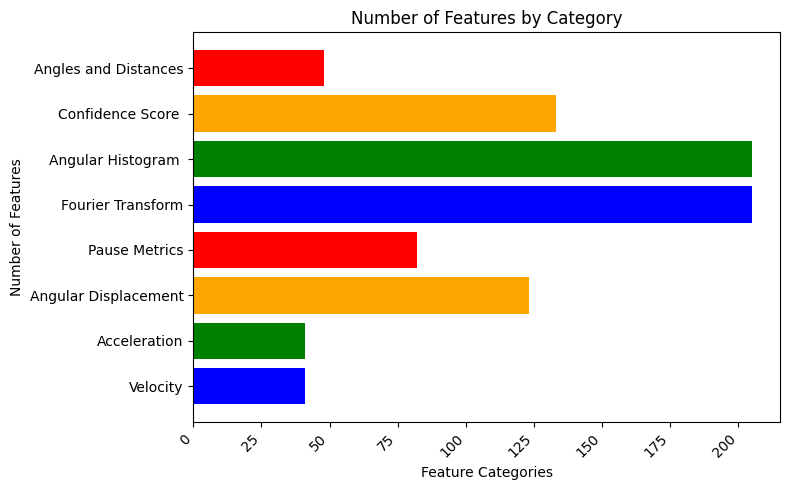

In [13]:
# Initialize a dictionary to group features into categories
feature_groups = {
    "Velocity": df.columns[df.columns.str.startswith('v_')],
    "Acceleration": df.columns[df.columns.str.startswith('a_')],
    "Angular Displacement": df.columns[df.columns.str.startswith('angdisp_')],
    "Pause Metrics": df.columns[df.columns.str.startswith('pause_ratio_') | df.columns.str.startswith('pause_duration_')],
    "Fourier Transform": df.columns[df.columns.str.startswith('fft_')],
    "Angular Histogram ": df.columns[df.columns.str.startswith('hist_')],
    "Confidence Score ": df.columns[df.columns.str.startswith('conf')]
}

# Identify features that do not fall into any category
categorized_features = [feature for features in feature_groups.values() for feature in features]
other_features = [feature for feature in df.columns if feature not in categorized_features]

# Add "Other" category
feature_groups["Angles and Distances"] = other_features

# Count the features in each category
category_counts = {category: len(features) for category, features in feature_groups.items()}

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.barh(category_counts.keys(), category_counts.values(), color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Feature Categories')
plt.ylabel('Number of Features')
plt.title('Number of Features by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()